In [ ]:
import re
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report

tqdm.pandas()
sns.set_style("darkgrid")
sns.set_context("notebook")
aug_regex = re.compile(r"<aug>(.*?)</aug>", re.DOTALL)

# Entropy Analysis

## Entropy Accuracy Curves

In [ ]:
sst5_data = pd.read_csv("../datasets/analysis/Kyle1668-boss-sentiment-bert-base-uncased-boss_sentiment-sst5-random-sst5-stabilityai-StableBeluga-7b-16-style_inference_log.csv")
display(sst5_data.head(3))
display(sst5_data.shape)

semval_data = pd.read_csv("../datasets/analysis/Kyle1668-boss-sentiment-bert-base-uncased-boss_sentiment-semval-random-semval-stabilityai-StableBeluga-7b-16-style_inference_log.csv")
display(semval_data.head(3))
display(semval_data.shape)

dynasent_data = pd.read_csv("../datasets/analysis/Kyle1668-boss-sentiment-bert-base-uncased-boss_sentiment-dynasent-random-dynasent-stabilityai-StableBeluga-7b-16-style_inference_log.csv")
display(dynasent_data.head(3))
display(dynasent_data.shape)

toxigen_data = pd.read_csv("../datasets/analysis/Kyle1668-boss-toxicity-bert-base-uncased-boss_toxicity-toxigen-random-toxigen-stabilityai-StableBeluga-7b-16-style_inference_log.csv")
display(toxigen_data.head(3))
display(toxigen_data.shape)

adv_civil_data = pd.read_csv("../datasets/analysis/Kyle1668-boss-toxicity-bert-base-uncased-boss_toxicity-adv_civil-random-adv_civil-stabilityai-StableBeluga-7b-16-style_inference_log.csv")
display(adv_civil_data.head(3))
display(adv_civil_data.shape)

implicit_hate_data = pd.read_csv("../datasets/analysis/Kyle1668-boss-toxicity-bert-base-uncased-boss_toxicity-implicit_hate-random-implicit_hate-stabilityai-StableBeluga-7b-16-style_inference_log.csv")
display(implicit_hate_data.head(3))
display(implicit_hate_data.shape)

agt_data = pd.read_csv("../datasets/analysis/Kyle1668-ag-news-bert-base-uncased-ag_news_twitter-random-test-stabilityai-StableBeluga-7b-16-style_inference_log.csv")
display(agt_data.head(3))
display(sst5_data.shape)

In [ ]:
for rewrites in sst5_data[sst5_data["input"].str.contains("`")]["input"].values:
    for current_rewrite in re.findall(aug_regex, rewrites):
        print(current_rewrite)
        print(ast.literal_eval(current_rewrite))
        break

## Entropy Accuracy Curves

In [57]:
thresholds = np.arange(0, 1, 0.00001)
# thresholds = np.arange(0, 1, 0.05)

baseline_perf = {
    "SST-5": 0.6847,
    "Sem Eval": 0.4498,
    "Dynasent": 0.4271,
    "ToxiGen": 0.6670,
    "Adv Civil": 0.3050,
    "Implicit Hate": 0.6454,
    "AG News Tweets": 0.8857,
}

In [ ]:
# create a fix where each plot is 5 inches wide and 5 inches tall with 2 padding
fig, axs = plt.subplots(ncols=3, figsize=(15, 6))

def calculate_entropy_threshold_jugments(inference_log_frame, dataset_name, half=False):
    threshold_scores = []
    threshold_rewrite_rates = []
    for t in tqdm(thresholds, desc="Calculating entropy threshold scores"):
        t_perf, t_rate = get_threshold_accuracy(t, inference_log_frame)
        threshold_scores.append(t_perf)
        threshold_rewrite_rates.append(t_rate)

    thresholds_frame = pd.DataFrame({"threshold": thresholds, "accuracy": threshold_scores, "rewrite_rate": threshold_rewrite_rates})

    # Set line splot
    coordinates = {
        "SST-5": 0,
        "ToxiGen": 1,
        "AG News Tweets": 2,
    }

    # Create a line plot with the coordinates in the grid
    figure = axs[coordinates[dataset_name]]
    figure = sns.lineplot(data=thresholds_frame, x="rewrite_rate", y="accuracy", label="TTA", ax=figure)
    figure.set_title(dataset_name, fontsize=18, pad=15)
    figure.set_xlabel("Augmentation Rate" if dataset_name == "ToxiGen" else "", labelpad=20, fontsize=14)
    figure.set_ylabel("Accuracy" if dataset_name == "SST-5" else "", labelpad=20, fontsize=14)
    figure.title.set_size(18)
    figure.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0%}".format(x)))
    figure.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2%}".format(x)))
    figure.set_xlim(left=0)
    figure.lines[0].set_linewidth(2)
    figure.legend_.remove()

    # Display max accuracy point
    accuracy_max_point = thresholds_frame[thresholds_frame["accuracy"] == thresholds_frame.max()["accuracy"]].sort_values("rewrite_rate").iloc[-1].to_dict()
    figure.plot(accuracy_max_point["rewrite_rate"],
                accuracy_max_point["accuracy"],
                marker="o",
                markersize=6,
                label="Optimal",
                )
    figure.annotate(f"{accuracy_max_point['accuracy']:.2%}",
                    (accuracy_max_point["rewrite_rate"], accuracy_max_point["accuracy"]),
                    textcoords="offset points",
                    xytext=(10, 0),
                    ha="left",
                    fontsize=10)

    # plot dashed gray line representing the baseline withour augmentation
    figure.plot([0, 1], [baseline_perf[dataset_name], baseline_perf[dataset_name]], color="gray", linestyle="--", linewidth=1.5, alpha=0.75, label="No TTA (Baseline)")
    # figure.axhline(baseline_perf[dataset_name], color="gray", linestyle="--", linewidth=1.5, alpha=0.75)
    if dataset_name == "SST-5":
        figure.set_ylim(bottom=baseline_perf[dataset_name] - 0.005)

    if dataset_name == "ToxiGen":
        figure.legend(loc="upper center", fontsize=12, frameon=False, ncol=3,
                      bbox_to_anchor=(0.5, -0.2),
                      )

    target_threshold = None
    if half is False:
        target_threshold = thresholds_frame[thresholds_frame["accuracy"] == thresholds_frame.max()["accuracy"]].sort_values("rewrite_rate").iloc[-1]
    else:
        thresholds_deltas_list = abs(thresholds_frame["rewrite_rate"] - 50).tolist()
        closest_half_delta = min(thresholds_deltas_list)
        closest_threshold_index = thresholds_deltas_list.index(closest_half_delta)
        target_threshold = thresholds_frame.iloc[closest_threshold_index]

    rewrite_rate = target_threshold["rewrite_rate"] / 100
    original_judgments = inference_log_frame.apply(lambda row: row["original judgment"] if row["original entropy"] < target_threshold["threshold"] else row["judgment"], axis=1)
    return original_judgments, rewrite_rate


def get_threshold_accuracy(threshold, inference_logs_frame):
    threshold_judgments = inference_logs_frame.apply(lambda row: row["original judgment"] if row["original entropy"] < threshold else row["judgment"], axis=1)
    report = classification_report(inference_logs_frame["label"], threshold_judgments, digits=4, output_dict=True)
    llm_call_count = (inference_logs_frame["original entropy"] >= threshold).sum()
    llm_call_rate = llm_call_count / len(inference_logs_frame)
    return report["accuracy"], llm_call_rate

calculate_entropy_threshold_jugments(sst5_data, "SST-5")
calculate_entropy_threshold_jugments(toxigen_data, "ToxiGen")
calculate_entropy_threshold_jugments(agt_data, "AG News Tweets")
fig.tight_layout(pad=1.0)
fig.savefig("../datasets/analysis/entropy_figures/main_acc_rewrite_curves.png", bbox_inches="tight")

## Appendix Entropy Figures

Calculating entropy threshold scores:   0%|          | 30/100000 [00:00<23:51, 69.86it/s]

Calculating entropy threshold scores:  22%|██▏       | 21681/100000 [1:06:57<4:06:23,  5.30it/s]Bad pipe message: %s [b'\x97BS\x04\x9cN\xaa\xd7~\xfa+\xe7\xd0\xcf\xb6\xfe\x03( k\xbb\xc3\xe0\\\x90\xd7\x7fsu\xd2\x05\xd2\xf42\xc4\xcc\xea\xa9h[pq\xc8\xe51t\x10!_it\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00', b'\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \x962\x14o\x87q\t\xc3\xbd\xa3\xa0\xe2\xc5\r\xc5\xa2\xe5b\x1b1\n\xc93d\x1be2\xa5\xe2tbC']
Bad pipe message: %s [b'\x95\x0f8\xde\x16VL\xdb\x08\x18\x02\x83\xdc\xdc\x99e\xfc\xaa ;\xdf~X%Yz\xbc\xb2\xd6\xb8\xa0\x1d:\x17\x90A\x9fZ\xa5\xca#\xdawT\x1c\xc6JJ\x9d\xf2{\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x0

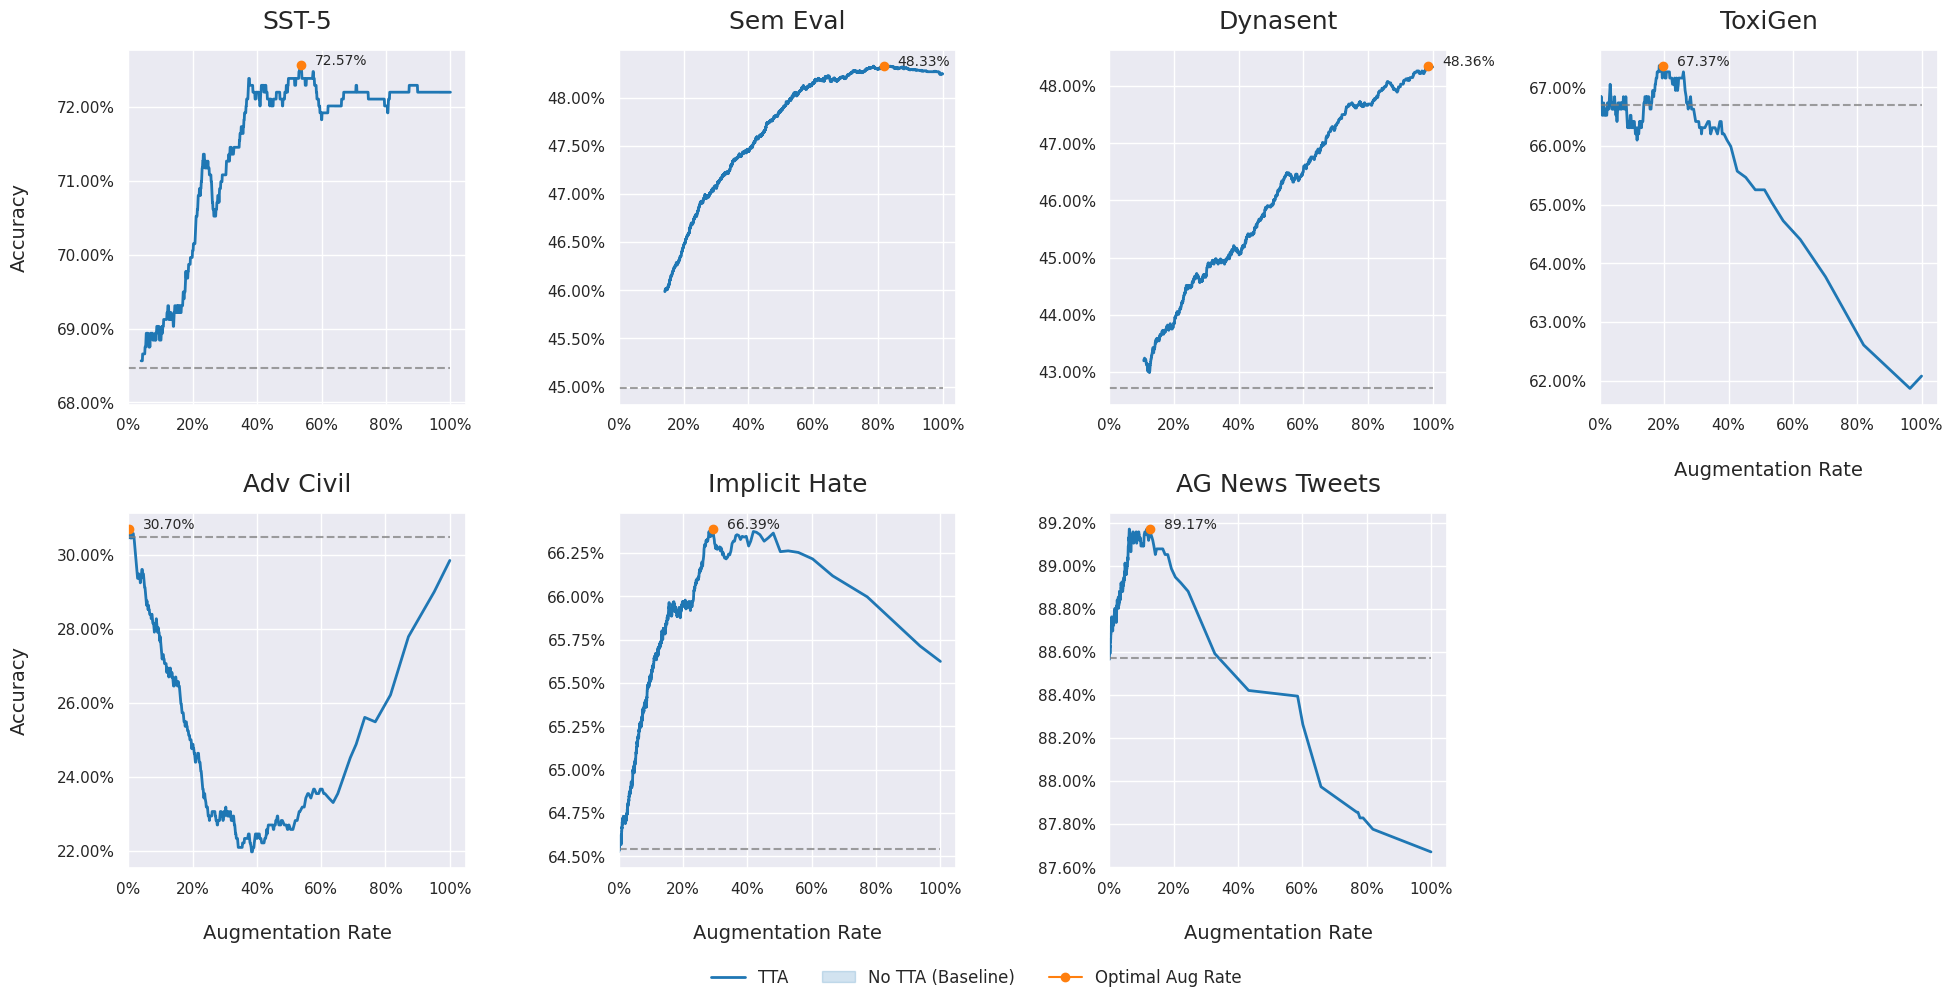

In [58]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 10), nrows=2)

def calculate_entropy_threshold_jugments(inference_log_frame, dataset_name, half=False):
    # thresholds = np.arange(0, 1, 0.0001)
    threshold_scores = []
    threshold_rewrite_rates = []
    for t in tqdm(thresholds, desc="Calculating entropy threshold scores"):
        t_perf, t_rate = get_threshold_accuracy(t, inference_log_frame)
        threshold_scores.append(t_perf)
        threshold_rewrite_rates.append(t_rate)

    thresholds_frame = pd.DataFrame({"threshold": thresholds, "accuracy": threshold_scores, "rewrite_rate": threshold_rewrite_rates})

    # Set line splot
    coordinates = {
        "SST-5": (0, 0),
        "Sem Eval": (0, 1),
        "Dynasent": (0, 2),
        "ToxiGen": (0, 3),
        "Adv Civil": (1, 0),
        "Implicit Hate": (1, 1),
        "AG News Tweets": (1, 2),
    }

    # Create a line plot with the coordinates in the grid
    figure = axs[coordinates[dataset_name][0]][coordinates[dataset_name][1]]
    figure = sns.lineplot(data=thresholds_frame, x="rewrite_rate", y="accuracy", label="TTA", ax=figure)
    figure.set_title(dataset_name, fontsize=18, pad=15)
    figure.set_xlabel("Augmentation Rate" if dataset_name in ["ToxiGen", "Adv Civil", "Implicit Hate", "AG News Tweets"] else "", labelpad=20, fontsize=14)
    figure.set_ylabel("Accuracy" if dataset_name in ["SST-5", "Adv Civil"] else "", labelpad=20, fontsize=14)
    figure.title.set_size(18)
    figure.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0%}".format(x)))
    figure.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2%}".format(x)))
    figure.set_xlim(left=0)
    figure.lines[0].set_linewidth(2)
    figure.legend_.remove()

    # Display max accuracy point
    accuracy_max_point = thresholds_frame[thresholds_frame["accuracy"] == thresholds_frame.max()["accuracy"]].sort_values("rewrite_rate").iloc[-1].to_dict()
    figure.plot(accuracy_max_point["rewrite_rate"],
                accuracy_max_point["accuracy"],
                marker="o",
                markersize=6,
                label="Optimal",
                )
    figure.annotate(f"{accuracy_max_point['accuracy']:.2%}",
                    (accuracy_max_point["rewrite_rate"], accuracy_max_point["accuracy"]),
                    textcoords="offset points",
                    xytext=(10, 0),
                    ha="left",
                    fontsize=10)

    figure.plot([0, 1], [baseline_perf[dataset_name], baseline_perf[dataset_name]], color="gray", linestyle="--", linewidth=1.5, alpha=0.75, label="No TTA (Baseline)")

    if dataset_name == "SST-5":
        figure.set_ylim(bottom=baseline_perf[dataset_name] - 0.005)

    target_threshold = None
    if half is False:
        target_threshold = thresholds_frame[thresholds_frame["accuracy"] == thresholds_frame.max()["accuracy"]].sort_values("rewrite_rate").iloc[-1]
    else:
        thresholds_deltas_list = abs(thresholds_frame["rewrite_rate"] - 50).tolist()
        closest_half_delta = min(thresholds_deltas_list)
        closest_threshold_index = thresholds_deltas_list.index(closest_half_delta)
        target_threshold = thresholds_frame.iloc[closest_threshold_index]

    rewrite_rate = target_threshold["rewrite_rate"] / 100
    original_judgments = inference_log_frame.apply(lambda row: row["original judgment"] if row["original entropy"] < target_threshold["threshold"] else row["judgment"], axis=1)
    return original_judgments, rewrite_rate


def get_threshold_accuracy(threshold, inference_logs_frame):
    threshold_judgments = inference_logs_frame.apply(lambda row: row["original judgment"] if row["original entropy"] < threshold else row["judgment"], axis=1)
    report = classification_report(inference_logs_frame["label"], threshold_judgments, digits=4, output_dict=True)
    llm_call_count = (inference_logs_frame["original entropy"] >= threshold).sum()
    llm_call_rate = llm_call_count / len(inference_logs_frame)
    return report["accuracy"], llm_call_rate


calculate_entropy_threshold_jugments(sst5_data, "SST-5")
calculate_entropy_threshold_jugments(semval_data, "Sem Eval")
calculate_entropy_threshold_jugments(dynasent_data, "Dynasent")
calculate_entropy_threshold_jugments(toxigen_data, "ToxiGen")
calculate_entropy_threshold_jugments(adv_civil_data, "Adv Civil")
calculate_entropy_threshold_jugments(implicit_hate_data, "Implicit Hate")
calculate_entropy_threshold_jugments(agt_data, "AG News Tweets")

fig.delaxes(axs[1, -1])
fig.legend(loc="lower center", fontsize=12, frameon=False, ncol=3, labels=["TTA", "No TTA (Baseline)", "Optimal Aug Rate"], bbox_to_anchor=(0.5, -0.025))
fig.tight_layout(pad=2.0)
fig.savefig("../datasets/analysis/entropy_figures/appendix_acc_rewrite_curves.png", bbox_inches="tight")

In [ ]:
sem_eval_original_entropies = semval_data["original entropy"].tolist()
figure = sns.scatterplot(data=semval_data, x=range(len(sem_eval_original_entropies)), y="original entropy", hue="outcome", s=5)
# set legend to the right vertically
figure.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, frameon=False, title="Outcome")
# make y axis log scale
figure.set_yscale("log")

In [ ]:
sst5_data[["original entropy", "outcome"]].groupby("outcome").describe()

In [ ]:
# heatmap between original entropy and outcome
pd.crosstab(sst5_data["original entropy"], semval_data["outcome"])